# Facial Landmark completion using a U-Net style CNN

## Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, SpatialDropout2D, Concatenate, LeakyReLU

from model_utility import IMAGE_SIZE, LandmarkCutoutImageIterator

In [2]:
tf.get_logger().setLevel('ERROR')

## Constants

### Data Constants

In [3]:
LANDMARKS_CSV_PATH = r'../Dataset/list_landmarks_align_celeba.csv'
RANDOM_STATE = 7
VAL_SPLIT = 0.1
BATCH_SIZE = 64
PLOTS_DPI = 150

### Model Constants

In [4]:
TRAIN_STEPS = 500
VAL_STEPS = 100
LEARNING_RATE = 0.001
LR_ALPHA = 0.3
EPOCHS = 30

### Callback Constants

In [5]:
ES_PATIENCE = 5
RLR_FACTOR = 0.1
RLR_PATIENCE = 3
RLR_MIN_LR = 0.00001
RLR_COOLDOWN = 2

## Data Loading

### Loading the csv containing the positions of the facial landmarks

In [6]:
landmark_df = pd.read_csv(LANDMARKS_CSV_PATH)
landmark_df.head()

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg         69        109         106         113      77     142   
1  000002.jpg         69        110         107         112      81     135   
2  000003.jpg         76        112         104         106     108     128   
3  000004.jpg         72        113         108         108     101     138   
4  000005.jpg         66        114         112         112      86     119   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0           73          152           108           154  
1           70          151           108           153  
2           74          156            98           158  
3           71          155           101           151  
4           71          147           104           150

In [7]:
landmark_df.shape

(202599, 11)

### Splitting the data into training and validation datasets

In [8]:
train_df, val_df = train_test_split(landmark_df, test_size = VAL_SPLIT, random_state =  RANDOM_STATE)
train_df.shape, val_df.shape

((182339, 11), (20260, 11))

In [9]:
train_df.head()

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
164385  164386.jpg         68        112         109         112      83   
113320  113321.jpg         69        112         108         111      88   
149551  149552.jpg         69        110         107         112      95   
88904   088905.jpg         69        112         108         111      88   
169391  169392.jpg         67        110         108         114     100   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
164385     135           69          151           107           151  
113320     142           67          152           110           152  
149551     132           75          152           103           152  
88904      135           71          151           105           153  
169391     125           70          150           110           152

In [10]:
val_df.head()

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
57636   057637.jpg         69        111         108         112      84   
166366  166367.jpg         69        112         108         111      88   
185783  185784.jpg         69        111         108         111      84   
139545  139546.jpg         69        111         108         111      91   
144025  144026.jpg         72        110         105         110      81   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
57636      138           71          151           107           152  
166366     133           74          152           103           152  
185783     136           70          152           107           151  
139545     134           73          152           105           152  
144025     131           76          154           101           155

### Creating sequence iterators
These sequences:
- Randomnly sample a batch of images ids from the df.
- Load the images corresponding to those ids.
- Randomnly apply one or more cutouts of varying size over a subset of facial landmarks.
- Create a mask representing the locations of the cutouts.
- Return the images with cutouts and their masks as inputs and the original images as output in batches.

In [11]:
train_iter = LandmarkCutoutImageIterator(train_df, BATCH_SIZE, TRAIN_STEPS)
val_iter = LandmarkCutoutImageIterator(val_df, BATCH_SIZE, VAL_STEPS)

train_iter, val_iter

(<model_utility.LandmarkCutoutImageIterator at 0x2d35abdbac0>,
 <model_utility.LandmarkCutoutImageIterator at 0x2d35abdbc10>)

### Sample training data

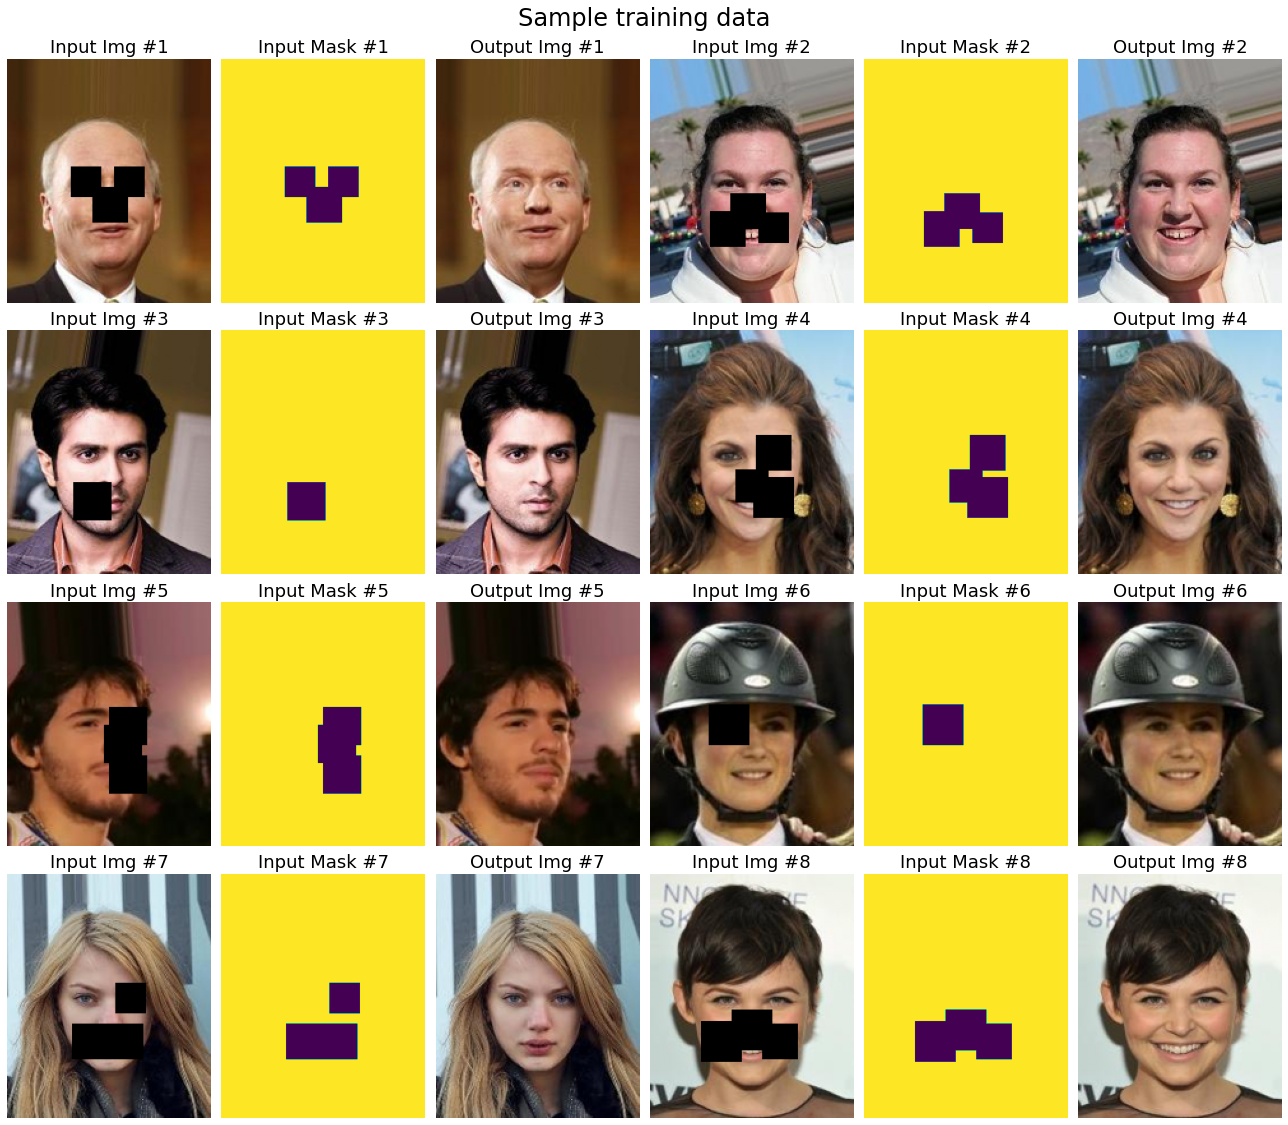

In [12]:
sample_data = train_iter[0]

fig, axes = plt.subplots(4, 6, figsize = (18, 16))

for i in range(8):
    axes[i//2][0 + (3 * (i % 2))].imshow(sample_data[0][0][i])
    axes[i//2][0 + (3 * (i % 2))].set_title(f"Input Img #{i + 1}", fontsize = 18)

    axes[i//2][1 + (3 * (i % 2))].imshow(sample_data[0][1][i])
    axes[i//2][1 + (3 * (i % 2))].set_title(f"Input Mask #{i + 1}", fontsize = 18)

    axes[i//2][2 + (3 * (i % 2))].imshow(sample_data[1][i])
    axes[i//2][2 + (3 * (i % 2))].set_title(f"Output Img #{i + 1}", fontsize = 18)

axes = axes.flatten()

for ax in axes:
    ax.axis(False)
    ax.grid(False)

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.suptitle("Sample training data", fontsize = 24)
plt.show()

### Creating a `tf.data.Dataset` from the sequence generator

In [13]:
output_types = ((tf.dtypes.float32, tf.dtypes.float32), tf.dtypes.float32)
output_shapes = (((BATCH_SIZE, *IMAGE_SIZE, 3), (BATCH_SIZE, *IMAGE_SIZE, 1)), (BATCH_SIZE, *IMAGE_SIZE, 3))
train_ds = Dataset.from_generator(train_iter, output_types = output_types, output_shapes = output_shapes).prefetch(buffer_size = AUTOTUNE)
val_ds = Dataset.from_generator(val_iter, output_types = output_types, output_shapes = output_shapes).prefetch(buffer_size = AUTOTUNE)

train_ds, val_ds

(<PrefetchDataset shapes: (((64, 192, 160, 3), (64, 192, 160, 1)), (64, 192, 160, 3)), types: ((tf.float32, tf.float32), tf.float32)>,
 <PrefetchDataset shapes: (((64, 192, 160, 3), (64, 192, 160, 1)), (64, 192, 160, 3)), types: ((tf.float32, tf.float32), tf.float32)>)

## Model Creation

In [14]:
def get_model():
    img_input_layer = Input(shape = (*IMAGE_SIZE, 3), name = 'Img_Input_Layer')
    mask_input_layer = Input(shape = (*IMAGE_SIZE, 1), name = 'Mask_Input_Layer')
    concat_inputs = Concatenate(name = "Concatenated_Inputs")([img_input_layer, mask_input_layer])

    conv_1 = Conv2D(32, 6, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_1')(concat_inputs)
    pool_1 = MaxPool2D(name = 'Max_Pool_1')(conv_1)
    conv_2 = Conv2D(64, 6, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_2')(pool_1)
    pool_2 = MaxPool2D(name = 'Max_Pool_2')(conv_2)
    spd_1 = SpatialDropout2D(0.1, name = 'SPD_1')(pool_2)
    
    conv_3 = Conv2D(128, 4, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_3')(spd_1)
    pool_3 = MaxPool2D(name = 'Max_Pool_3')(conv_3)
    conv_4 = Conv2D(256, 4, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_4')(pool_3)
    pool_4 = MaxPool2D(name = 'Max_Pool_4')(conv_4)
    spd_2 = SpatialDropout2D(0.1, name = 'SPD_2')(pool_4)
    
    conv_5 = Conv2D(512, 2, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_5')(spd_2)
    pool_5 = MaxPool2D(name = 'Max_Pool_5')(conv_5)
    spd_3 = SpatialDropout2D(0.1, name = 'SPD_3')(pool_5)
    
    conv_t_1 = Conv2DTranspose(256, 2, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_1')(spd_3)
    concat_1 = Concatenate(name = 'Concat_1')([conv_t_1, pool_4])
    spd_4 = SpatialDropout2D(0.1, name = 'SPD_4')(concat_1)
    
    conv_t_2 = Conv2DTranspose(128, 4, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_2')(spd_4)
    conv_t_3 = Conv2DTranspose(64, 4, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_3')(conv_t_2)
    concat_2 = Concatenate(name = 'Concat_2')([conv_t_3, pool_2])
    spd_5 = SpatialDropout2D(0.1, name = 'SPD_5')(concat_2)
    
    conv_t_4 = Conv2DTranspose(32, 6, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_4')(spd_5)
    conv_t_5 = Conv2DTranspose(3, 6, padding = 'same', strides = 2, activation = 'sigmoid', name = 'Conv_T_5')(conv_t_4)

    return Model(inputs = [img_input_layer, mask_input_layer], outputs = conv_t_5, name = 'Facial_Landmark_Completion')

model = get_model()
model.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['mse'])
model.summary()

Model: "Facial_Landmark_Completion"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Img_Input_Layer (InputLayer)    [(None, 192, 160, 3) 0                                            
__________________________________________________________________________________________________
Mask_Input_Layer (InputLayer)   [(None, 192, 160, 1) 0                                            
__________________________________________________________________________________________________
Concatenated_Inputs (Concatenat (None, 192, 160, 4)  0           Img_Input_Layer[0][0]            
                                                                 Mask_Input_Layer[0][0]           
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 192, 160, 32) 4640        Concaten

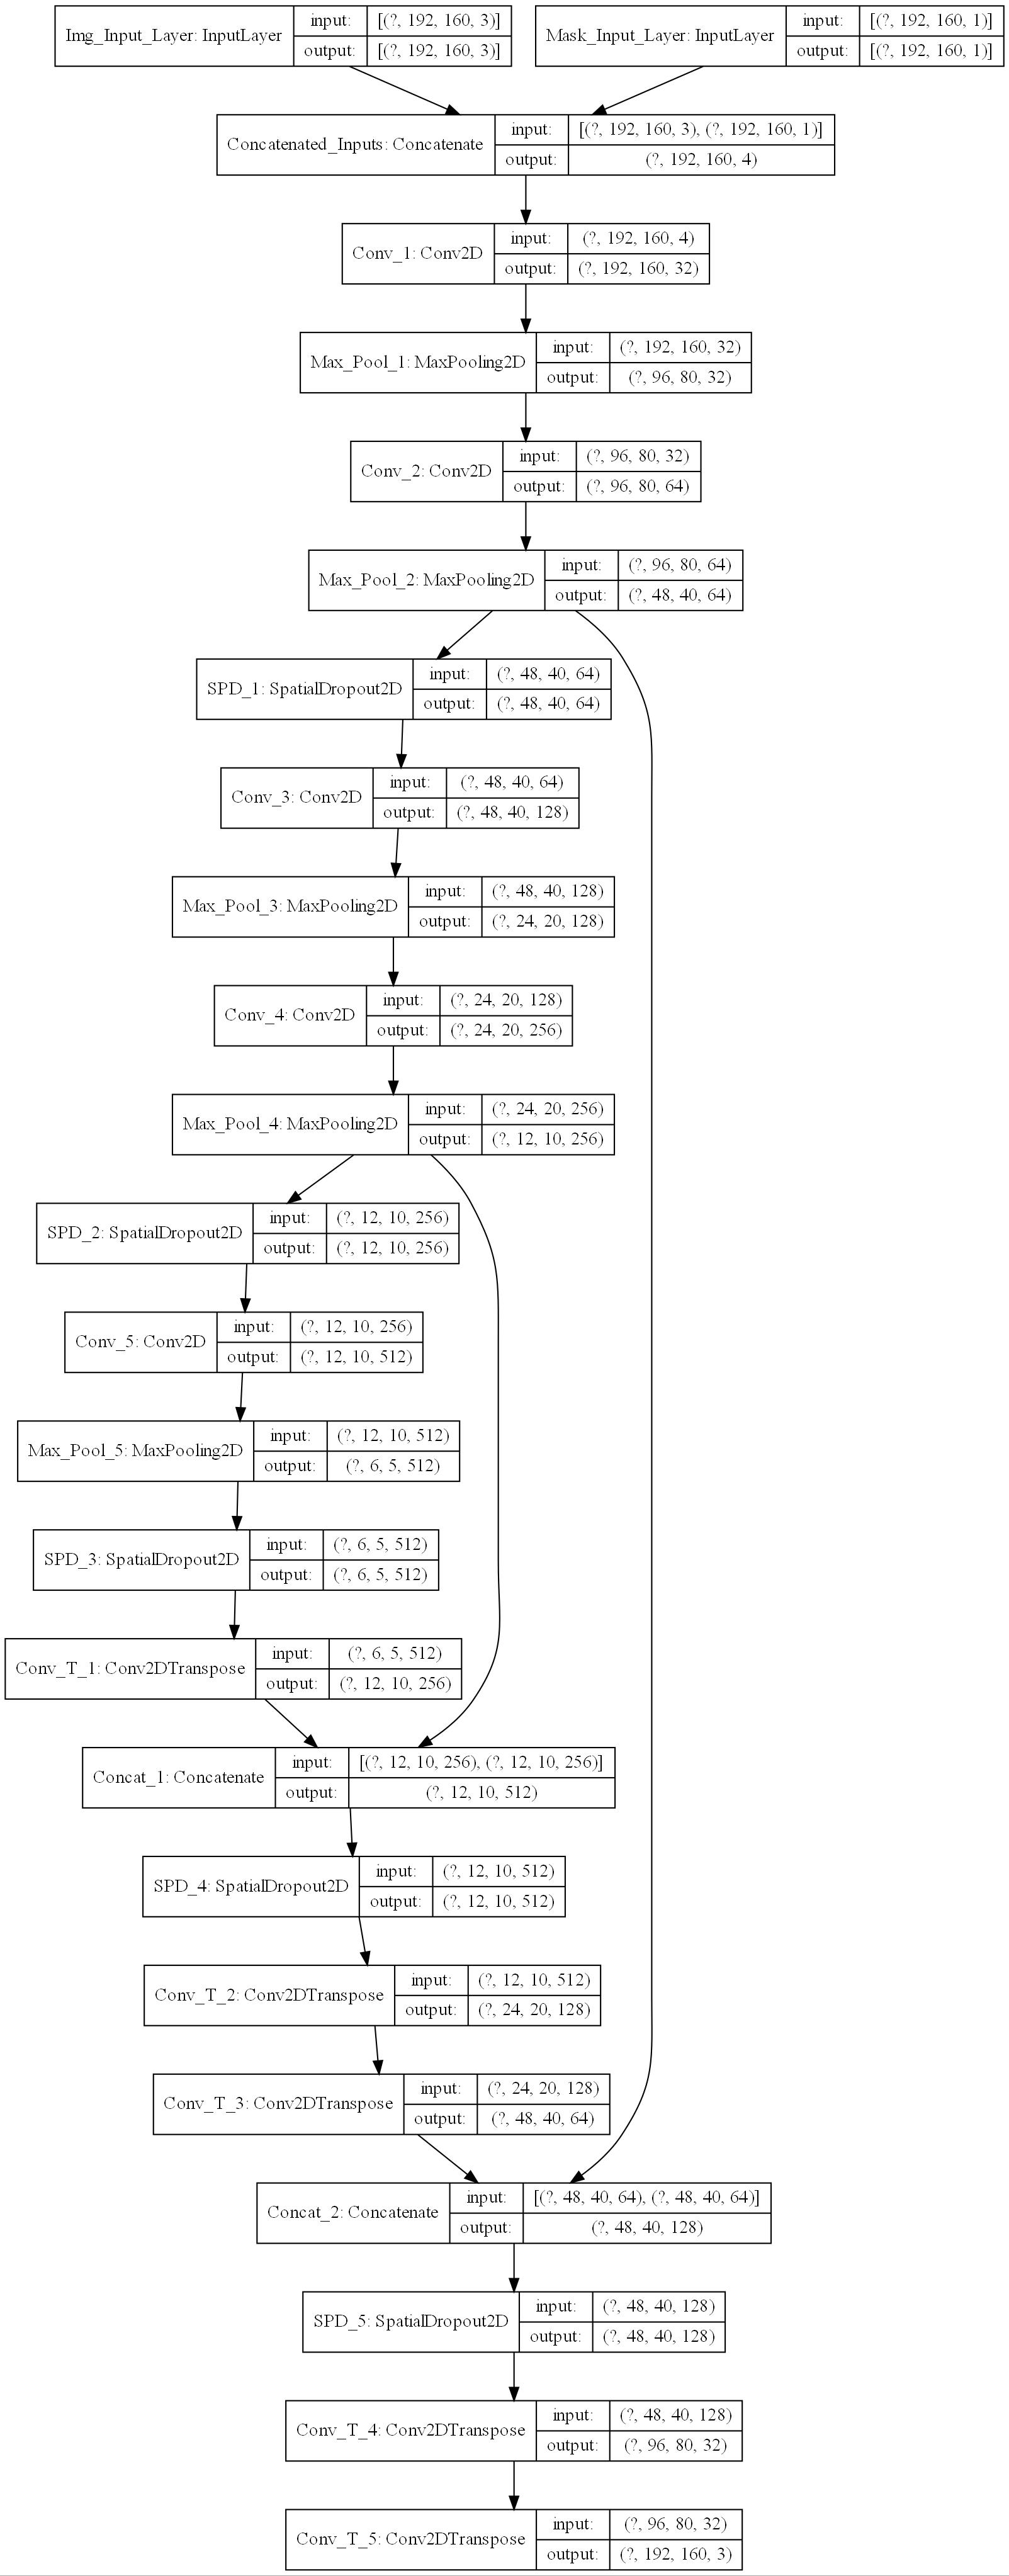

In [15]:
plot_model(model, to_file = 'model.jpg', show_shapes = True, dpi = PLOTS_DPI)

## Model Training

### Callbacks

In [16]:
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    patience = ES_PATIENCE, 
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = RLR_FACTOR, 
    patience = RLR_PATIENCE, 
    min_lr = RLR_MIN_LR, 
    cooldown = RLR_COOLDOWN, 
    verbose = 1
)

early_stop, reduce_lr

(<tensorflow.python.keras.callbacks.EarlyStopping at 0x2d310e75fd0>,
 <tensorflow.python.keras.callbacks.ReduceLROnPlateau at 0x2d310e75f70>)

### Training history

In [17]:
%%time

history = model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS, callbacks = [early_stop, reduce_lr])

Epoch 1/30
500/500 [==============================] - 809s 2s/step - loss: 0.4903 - mse: 0.0071 - val_loss: 0.4788 - val_mse: 0.0027
Epoch 2/30
500/500 [==============================] - 1074s 2s/step - loss: 0.4775 - mse: 0.0025 - val_loss: 0.4775 - val_mse: 0.0021
Epoch 3/30
500/500 [==============================] - 841s 2s/step - loss: 0.4763 - mse: 0.0020 - val_loss: 0.4760 - val_mse: 0.0016
Epoch 4/30
500/500 [==============================] - 780s 2s/step - loss: 0.4763 - mse: 0.0018 - val_loss: 0.4759 - val_mse: 0.0015
Epoch 5/30
500/500 [==============================] - 682s 1s/step - loss: 0.4759 - mse: 0.0017 - val_loss: 0.4752 - val_mse: 0.0014
Epoch 6/30
500/500 [==============================] - 596s 1s/step - loss: 0.4751 - mse: 0.0016 - val_loss: 0.4743 - val_mse: 0.0014
Epoch 7/30
500/500 [==============================] - 284s 567ms/step - loss: 0.4746 - mse: 0.0015 - val_loss: 0.4766 - val_mse: 0.0013
Epoch 8/30
500/500 [==============================] - 271s 543ms/

## Model Evaluation

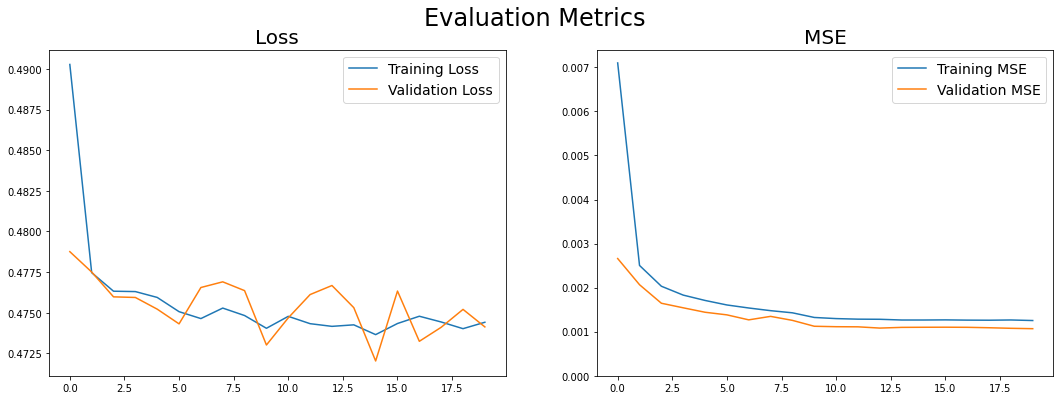

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mse = history.history['mse']
val_mse = history.history['val_mse']

epochs_range = history.epoch

plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right', fontsize = 14)
plt.title('Loss', fontsize = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mse, label = 'Training MSE')
plt.plot(epochs_range, val_mse, label = 'Validation MSE')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, None)
plt.title('MSE', fontsize = 20)

plt.suptitle("Evaluation Metrics", fontsize = 24)
plt.savefig('loss.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Sample Predictions

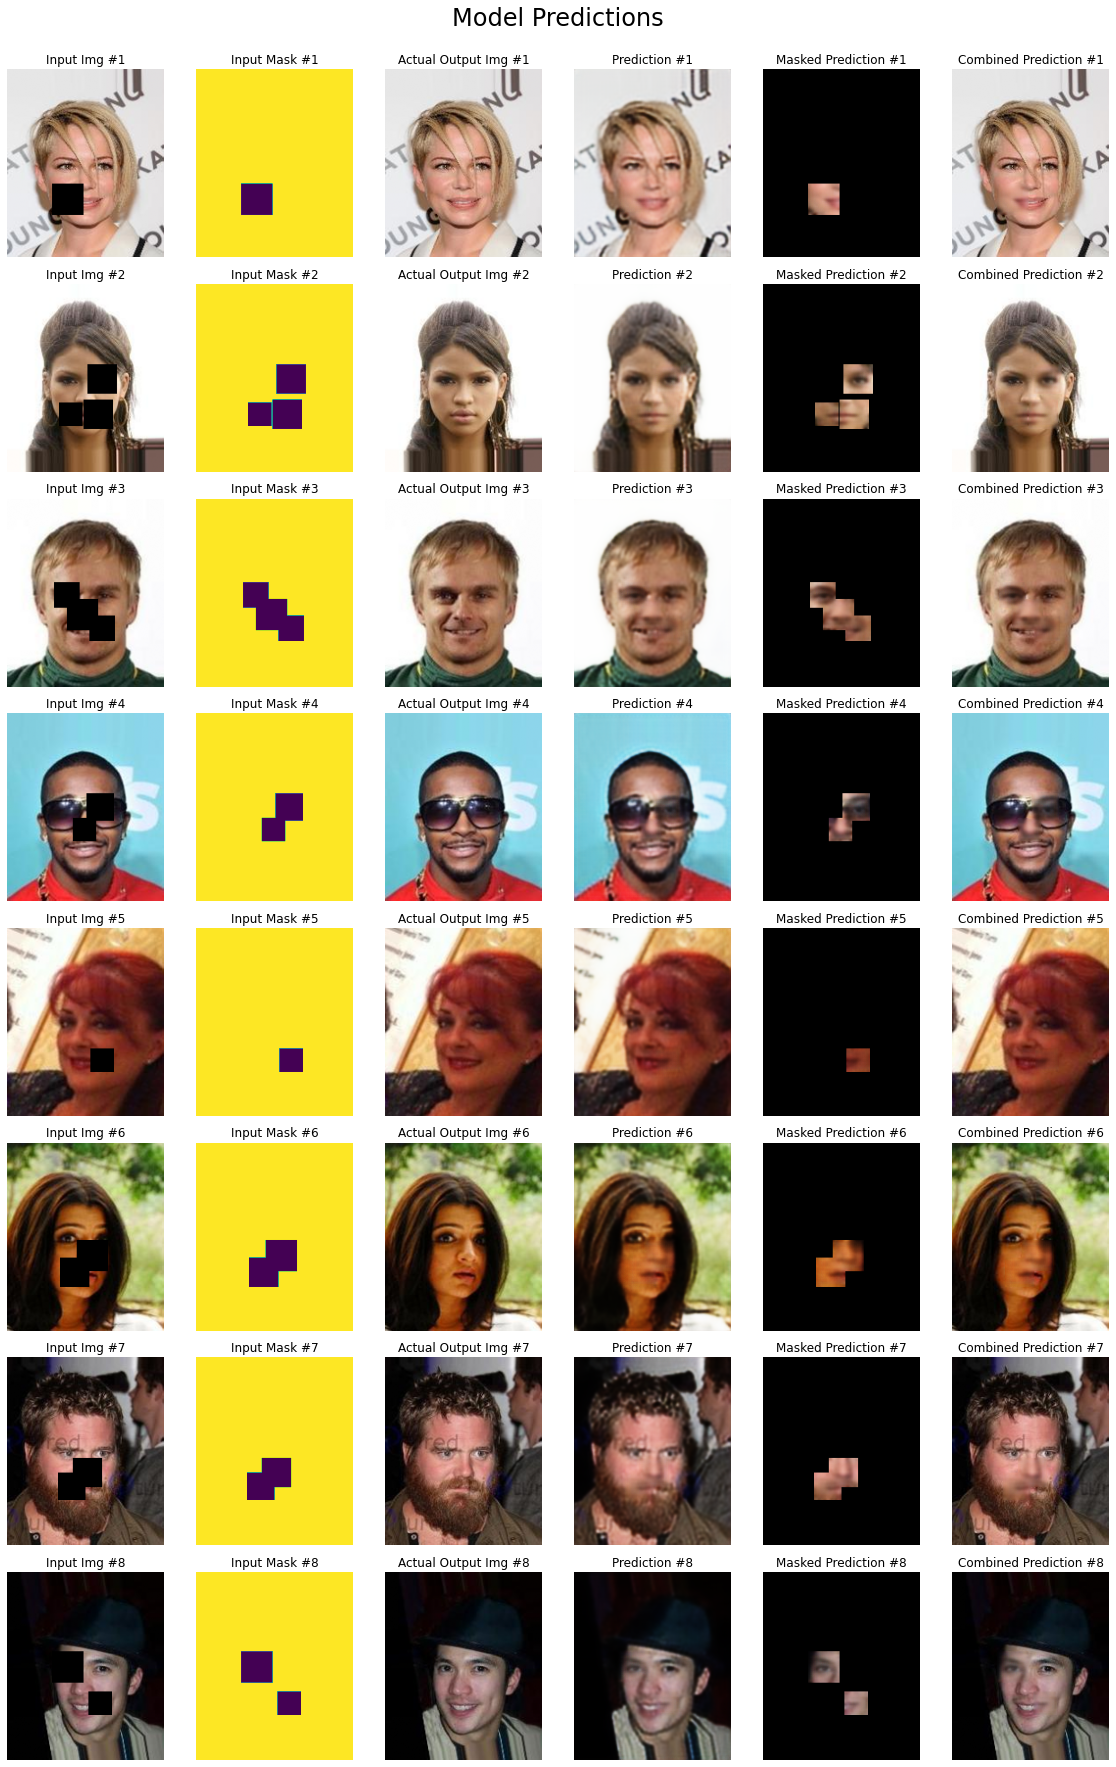

In [19]:
sample_data = val_iter[0][:8]
imgs = img = sample_data[0][0]
masks = mask = sample_data[0][1]
preds = model.predict(sample_data[0])

fig, axes = plt.subplots(8, 6, figsize = (16, 25))

for i in range(8):

    axes[i][0].imshow(imgs[i])
    axes[i][0].set_title(f"Input Img #{i + 1}")

    axes[i][1].imshow(masks[i])
    axes[i][1].set_title(f"Input Mask #{i + 1}")

    axes[i][2].imshow(sample_data[1][i])
    axes[i][2].set_title(f"Actual Output Img #{i + 1}")

    axes[i][3].imshow(preds[i])
    axes[i][3].set_title(f"Prediction #{i + 1}")

    masked_pred = preds[i] * (1 - masks[i])

    axes[i][4].imshow(masked_pred)
    axes[i][4].set_title(f"Masked Prediction #{i + 1}")

    combined_pred = (imgs[i] * masks[i]) + masked_pred

    axes[i][5].imshow(combined_pred)
    axes[i][5].set_title(f"Combined Prediction #{i + 1}")

axes = axes.flatten()

for ax in axes:
    ax.axis(False)
    ax.grid(False)

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.suptitle("Model Predictions", fontsize = 24)
plt.savefig('predictions.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Saving the model

In [20]:
model.save("face_completion")